In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import data_receiver

In [ ]:
%matplotlib widget

# functions for kalman filter

In [36]:
I3 = np.diag((1, 1, 1))

def skew(x):
    '''
        takes in a 3d column vector
        returns its skew-symmetric matrix
    '''

    x = x.T[0]
    return np.array([
        [0, -x[2], x[1]],
        [x[2], 0, -x[0]],
        [-x[1], x[0], 0]
    ])

def Omega(x):
    '''returns the Omega matrix defined in the paper'''

    l = np.vstack((-skew(x), -x.T))
    zero = np.array([0])
    r = np.vstack((x, zero))
    return np.hstack((l, r))

def C(q):
    '''same as quad_rotate() but seems less accurate'''

    qv = q[0:3, :]
    qc = q[3, :]

    tmp1 = (qc**2 - qv.T @ qv) * I3
    tmp2 = - 2 * qc * skew(qv)
    tmp3 = 2 * qv @ qv.T
    return tmp1 + tmp2 + tmp3

def quad_rotate(q, x):
    '''rotate x with quaternion q, returns the rotated x'''

    q = q.T[0]
    q1 = q[0]
    q2 = q[1]
    q3 = q[2]
    q4 = q[3]
    transform = np.array([
        [q4**2+q1**2-q2**2-q3**2, 2*q1*q2-2*q3*q4, 2*q1*q3+2*q2*q4],
        [2*q1*q2+2*q3*q4, q4**2-q1**2+q2**2-q3**2, 2*q2*q3-2*q1*q4],
        [2*q1*q3-2*q2*q4, 2*q2*q3+2*q1*q4, q4**2-q1**2-q2**2+q3**2]
    ])

    res = transform @ x
    return res

def S(q):
    '''returns the S matrix defined in the paper'''

    qv = q[0:3, :]
    qc = q[3, :]

    tmp = qc * I3 + skew(qv)
    return np.vstack((tmp, -qv.T))

def Fk(w):
    '''state transfer matrix, w is the measured angular velocity'''

    I4 = np.diag((1, 1, 1, 1))
    w_norm = np.linalg.norm(w)

    # the rotation angle
    beta = w_norm * (DT/2)
    print(beta)

    return I4 * np.cos(beta) + Omega(w) * (np.sin(beta) / w_norm)

def Fk1(w):
    '''simpler state transfer matrix'''

    w = np.vstack((w, np.array([[0]]).T))
    return np.diag((1,1,1,1)) + 0.5 * DT * w

# define constants

In [3]:
# sampling rate
DT = 0.01 # s

# the initialization interval
ts = 0.5 # s

# initial error estimation
sigma_P = 0.0003 # initial angular error
sigma_Q = 0.00003 # discrete time error
sigma_R = 0.025 # measurement noise

# data processing
data order: gyroscorpe, accelerometer, magnetometer

In [4]:
r = data_receiver.Receiver()

data = []

for line in r.receive():
    data.append(line.split(','))

data = np.array(data, dtype = np.float)

# discard the first and last few readings
# for some reason they fluctuate a lot
w = data[5:-5, 0:3]
a = data[5:-5, 3:6]
m = data[5:-5, 6:9]

if(np.shape(w)[0] < ts/DT):
    print("not enough data!")

## Initialization

In [37]:
w_bias = w[:int(ts/DT)].mean(axis = 0)

g_avg = a[:int(ts/DT)].mean(axis = 0)
g_dir = - g_avg / np.linalg.norm(g_avg)
g_dir = np.array([g_dir]).T

# cut the initialization data
# w = w[int(ts/DT):] - w_bias
w = w[int(ts/DT):]
a = a[int(ts/DT):]

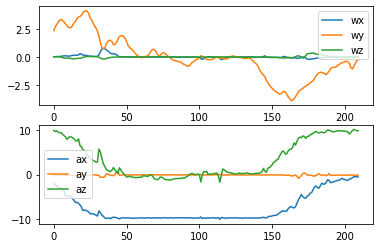

In [38]:
plt.subplot(211)
plt.plot(w[:, 0], label='wx')
plt.plot(w[:, 1], label='wy')
plt.plot(w[:, 2], label='wz')
plt.legend()

plt.subplot(212)
plt.plot(a[:, 0], label='ax')
plt.plot(a[:, 1], label='ay')
plt.plot(a[:, 2], label='az')
plt.legend()

[[ 0.02018861  0.01565222 -0.99967366]]


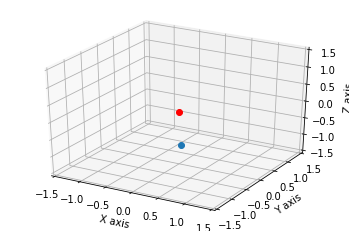

In [39]:
g_fig = plt.figure()
ax = g_fig.add_subplot(111, projection='3d')
# ax.plot(points[:, 0], points[:, 1], points[:, 1], 'o')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.plot(g_dir[0], g_dir[1], g_dir[2], 'o')
ax.plot([0], [0], [0], 'ro')

print(g_dir.T)

## Kalman Filter

In [40]:
q = np.array([[0. ,0., 0., 1.]]).T
ori = -g_dir # the intial orientation, pointing upwards
P = sigma_P * I3
Q = sigma_Q * DT * I3
R = sigma_R * I3

In [41]:
k = 0
orientation = []
g = []

while k < np.shape(w)[0]:
    wk = np.array([w[k]]).T

    # update orientation q
    q = Fk(wk) @ q
    # normalize q to minimize error
    q = q / np.linalg.norm(q)  

    # estimate covarience matrix
    Phi = I3 - skew(wk) * DT
    P = Phi @ P @ Phi.T + Q

    # update gravity direction
    # g_dir = C(q) @ g_dir
    g_dir = quad_rotate(q, g_dir)

    # calculate Kalman gain
    H = skew(g_dir)
    tmp = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(tmp)

    # get gravity measurement from raw a data
    # lowpass filter
    # wc = 0.4 # rad/s


    # delta_theta = K @ (m_g_dir - g_dir)

    # update q
    # q = q + S(q) @ (delta_theta / 2)
    # # normalize q
    # q = q / np.linalg.norm(q)

    # update P
    P = (I3 - K @ H) @ P @ (I3 - K @ H).T + K @ R @ K.T

    # ori = C(q) @ ori
    ori = quad_rotate(q, ori)
    orientation.append(ori.T[0])
    # points.append(q[0:3, :].T[0])
    g.append(g_dir.T[0])
    k += 1

orientation = np.array(orientation)
g = np.array(g)

### plotting results

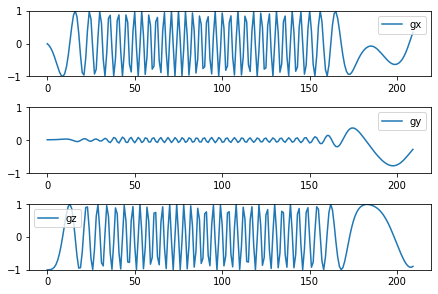

In [42]:
plt.subplot(311)
plt.plot(g[:, 0], label='gx')
plt.legend()
plt.ylim(-1, 1)

plt.subplot(312)
plt.plot(g[:, 1], label='gy')
plt.legend()
plt.ylim(-1, 1)

plt.subplot(313)
plt.plot(g[:, 2], label='gz')
plt.legend()
plt.ylim(-1, 1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

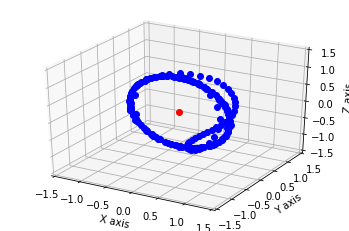

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(orientation[:, 0], orientation[:, 1], orientation[:, 2], 'bo')
# ax.plot(g[:, 0], g[:, 1], g[:, 2], 'go')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.plot([0], [0], [0], 'ro')